# DEMO


### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import geocoder
import mysql.connector
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
ORIGIN_PATH = os.getcwd()

### Defining Utility functions and classes

In [2]:
def getSubjectNum(fileName) :
        import re
        n = re.findall(r'\d+', fileName)
        return int(n[0])


In [3]:
class acceleration_chest_X :
     id =0
     name = 'acceleration_chest_X'

class acceleration_chest_Y :
     id =1
     name = 'acceleration_chest_Y'

class acceleration_chest_Z :
     id =2
     name = 'acceleration_chest_Z'

class ECG_lead_1 :
     id=3
     name = 'ECG_lead_1'

class ECG_lead_2 :
     id=4
     name = 'ECG_lead_2'

class acceleration_left_ankle_X :
     id =5
     name = 'acceleration_left_ankle_X'

class acceleration_left_ankle_Y :
     id =6
     name = 'acceleration_left_ankle_Y'

class acceleration_left_ankle_Z :
     id =7
     name = 'acceleration_left_ankle_Z'

class gyro_left_ankle_X :
     id =8
     name = 'gyro_left_ankle_X'

class gyro_left_ankle_Y :
     id =9
     name = 'gyro_left_ankle_Y'

class gyro_left_ankle_Z :
     id =10
     name = 'gyro_left_ankle_Z'

class magnetometer_left_ankle_X :
     id =11
     name = 'magnetometer_left_ankle_X'

class magnetometer_left_ankle_Y :
     id =12
     name = 'magnetometer_left_ankle_Y'

class magnetometer_left_ankle_Z :
     id =13
     name = 'magnetometer_left_ankle_Z'

class acceleration_right_lower_arm_X :
     id =14
     name = 'acceleration_right_lower_arm_X'

class acceleration_right_lower_arm_Y :
     id =15
     name = 'acceleration_right_lower_arm_Y'

class acceleration_right_lower_arm_Z :
     id =16
     name = 'acceleration_right_lower_arm_Z'

class gyro_right_lower_arm_X :
     id =17
     name = 'gyro_right_lower_arm_X'

class gyro_right_lower_arm_Y :
     id =18
     name = 'gyro_right_lower_arm_Y'

class gyro_right_lower_arm_Z :
     id =19
     name = 'gyro_right_lower_arm_Z'

class magnetometer_right_lower_arm_X :
     id =20
     name = 'magnetometer_right_lower_arm_X'

class magnetometer_right_lower_arm_Y :
     id =21
     name = 'magnetometer_right_lower_arm_Y'


class magnetometer_right_lower_arm_Z :
     id =22
     name = 'magnetometer_right_lower_arm_Z'
    

In [4]:
class mHealthSensor:
    def __init__(self,TYPE,freq=50,sourceData="mHealth_subject3.log",realisitc=False):
        self.frequency=freq
        self.sourceData=sourceData
        self.column=TYPE.id
        self.name=TYPE.name
        self.realisitc=realisitc
        self.subjectNum=getSubjectNum(self.sourceData)
        self.generateInputFile()
        self.datapool=pd.DataFrame(np.array([]))
    
    def generateInputFile(self):
        X =  np.array([])
        Y =  np.array([])
        df = pd.read_csv(self.sourceData, header=None, delim_whitespace=True)
        df = df[df[23]!=0] #drop 0 labeled features
        readings_df = pd.DataFrame(df[self.column].copy())
        targets_df = pd.DataFrame(df[23].copy())
        reading_np = readings_df.values

        rps=self.frequency
        activities=range(0,13)
        
        # #         segmentation
        for i in range(int(readings_df.shape[0]/rps)):
            if  float(targets_df[i*rps:i*rps+rps].mean()) in activities:
                Y=np.append(Y,targets_df[i*rps:i*rps+rps].mean()) #new
                X=np.append(X,readings_df[i*rps:i*rps+rps].values)

        X=X.reshape(-1,rps)
        OutDF = pd.DataFrame(X)
        OutDF['labels']=Y
        OutDF.reset_index
        OutDF.to_csv(self.name+"_subject"+str(self.subjectNum), sep='\t',index=False)

    #returns value , target
    def getReading(self,activity=1):
        if self.realisitc:
            import time
            time.sleep(1)
        if self.datapool.empty == True:
            self.datapool= pd.read_csv(self.name+"_subject"+str(self.subjectNum), sep='\t',index_col=False)
        readings = self.datapool.loc[self.datapool.labels==activity,]
        randIndex = np.random.randint(0,len(readings))
        return np.array(readings.iloc[randIndex,range(0,self.frequency)]), readings.iloc[randIndex,self.frequency]


### Downloading models from the cloud

In [5]:
!pip install googledrivedownloader

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd
if not os.path.isfile(os.path.join("MODELS","ecg.sav")):
    gdd.download_file_from_google_drive(file_id='1ZKUsE9l-iHZ7_z7OKUpcG6BbiJhKsdy0',
                                    dest_path=os.path.join("MODELS","ecg.sav"))
if not os.path.isfile(os.path.join("MODELS","knn.sav")):
    gdd.download_file_from_google_drive(file_id='1WpZuJLhcMaI40DWGVPeJyijSWSsWngze',
                                    dest_path=os.path.join("MODELS","knn.sav"))

In [7]:
from sklearn.externals import joblib

In [8]:
ACTUATOR_BUFFER=[]
ECG_BUFFER=[]
os.chdir(ORIGIN_PATH)
source = os.path.join(ORIGIN_PATH,"MHEALTHDATASET","mHealth_subject3.log")
gyroSensor = mHealthSensor(TYPE=gyro_left_ankle_Z,freq=50,sourceData=source,realisitc=True)
ECGSensor  = mHealthSensor(TYPE=ECG_lead_1,freq=50,sourceData=source,realisitc=True)
ActuatorsPredictor=joblib.load(os.path.join("MODELS","knn.sav"))
ECGPredictor=joblib.load(os.path.join("MODELS","ecg.sav"))


In [9]:
def sendEmrgency(patientID=38,description=""):
    cnx = mysql.connector.connect(user='root', password='',
                              host='localhost',
                              database='ehealth2')
    cursor = cnx.cursor()
    g = geocoder.ip('me')
    PatientID= patientID
    Latitude= g.latlng[0]
    Longitude= g.latlng[1]
    Description=description
    TimeOfOccurrence= time.strftime('%Y-%m-%d %H:%M:%S')
    Flag= 1
    query = "INSERT INTO `emergencycase` (`EmergencyCaseID`, `PatientID`, `Latitude`, `Longitude`,`Description` ,`TimeOfOccurrence`, `Flag`) VALUES (NULL, '"+str(PatientID)+"', '"+str(Latitude)+"', '"+str(Longitude)+"', '"+str(Description)+"', '"+str(TimeOfOccurrence)+"', '"+str(Flag)+"');"
    cursor.execute(query)
    cnx.close()

## DEMO


Enter patient ID:
ID:38
[1] Normal behaviour
[2] Anomalous behaviour
Choice :2
What's the user actually doing now?
[1] Standing still
[2] Sitting and relaxing
[3] Lying down
[4] Walking
[5] Climbing stairs
[6] Waist bends forward
[7] Frontal elevation of arms
[8] Knees bending (crouching)
[9] Cycling
[10] Jogging
[11] Running
[12] Jump front & back
current activity:5
reading gyroscope sensor
[ 0.9666    0.9666    0.95285   0.95285   0.95285   0.99804   0.99804
  0.99804   0.99804   0.98035   0.98035   0.98035   0.95285   0.95285
  0.95285   0.95285   0.91749   0.91749   0.91749   0.8998    0.8998
  0.8998    0.8998    0.8998    0.8998    0.8998    0.78193   0.78193
  0.78193   0.72299   0.72299   0.72299   0.72299   0.68173   0.68173
  0.68173   0.59528   0.59528   0.59528   0.59528   0.33792   0.33792
  0.33792  -0.015717 -0.015717 -0.015717 -0.15324  -0.15324  -0.15324
 -0.15324 ]
reading ecg sensor
[ 0.12977  -0.016745 -0.11303  -0.13815  -0.14233  -0.10884  -0.16327
 -0.2428   -0.3

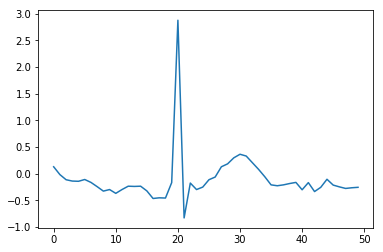

Activity Predicted (via GYR):  5.0
Activity Predicted (via ECG):  6.0
ANOMALY
Actuators are showing that the user is Climbing stairs but ECG readings indicates that the activity is Waist bends forward


In [12]:
labels=["Transition","Standing still","Sitting and relaxing","Lying down","Walking","Climbing stairs","Waist bends forward","Frontal elevation of arms","Knees bending (crouching)","Cycling","Jogging","Running","Jump front & back"]

import time
while(True):
    clear_output()
    print("Enter patient ID:")
    patientID=int(input("ID:"))
    print("[1] Normal behaviour")
    time.sleep(0.1)
    print("[2] Anomalous behaviour")
    time.sleep(0.1)
    behaviour = int(input("Choice :"))
    print("What's the user actually doing now?")
    time.sleep(0.1)
    print("[1] Standing still")
    time.sleep(0.1)
    print("[2] Sitting and relaxing")
    time.sleep(0.1)
    print("[3] Lying down")
    time.sleep(0.1)
    print("[4] Walking")
    time.sleep(0.1)
    print("[5] Climbing stairs")
    time.sleep(0.1)
    print("[6] Waist bends forward")
    time.sleep(0.1)
    print("[7] Frontal elevation of arms")
    time.sleep(0.1)
    print("[8] Knees bending (crouching)")
    time.sleep(0.1)
    print("[9] Cycling")
    time.sleep(0.1)
    print("[10] Jogging")
    time.sleep(0.1)
    print("[11] Running")
    time.sleep(0.1)
    print("[12] Jump front & back")
    time.sleep(0.1)
    activity=int(input("current activity:"))
    
    print("reading gyroscope sensor")
    time.sleep(0.5)
    actuator_reading,Activity_actual_GYR=gyroSensor.getReading(activity=activity)
    print(actuator_reading)
    
    print("reading ecg sensor")
    time.sleep(0.5)
    if behaviour == 1 :
        ecg_reading,Activity_actual_ECG=ECGSensor.getReading(activity=activity)
    else :
        ecg_reading,Activity_actual_ECG=ECGSensor.getReading(activity=(activity+1)%12)
    print(ecg_reading)
    df = pd.DataFrame(ecg_reading)
    plt.plot(df)
    plt.show()

    #Activity_predited_ECG = ECGPredictor.predict(np.array(ecg_reading).reshape(1, -1))
#     Activity_predited_GYR = ActuatorsPredictor.predict(np.array(actuator_reading).reshape(1, -1))
    
    Activity_predited_ECG = Activity_actual_ECG
    Activity_predited_GYR = Activity_actual_GYR
    
    print("Activity Predicted (via GYR): ",Activity_predited_GYR)
    print("Activity Predicted (via ECG): ",Activity_predited_ECG)
    if(Activity_predited_GYR == Activity_predited_ECG):
        print("NORMAL BEHAVIOUR")
    else:
        msg = "Actuators are showing that the user is " + labels[int(Activity_predited_GYR)] + " but ECG readings indicates that the activity is "+labels[int(Activity_predited_ECG)]
        print("ANOMALY")
        print(msg)
        sendEmrgency(patientID,msg)
#     input("[Press any key to continue]")
    break


In [ ]:
# ### import sys
# import subprocess
# path = "C:\\Users\\pcroot\\Desktop\\jj.jpeg"
# # def openImage(path):
# imageViewerFromCommandLine = {'linux':'xdg-open',
#                               'win32':'explorer',
#                               'darwin':'open'}[sys.platform]
# subprocess.run([imageViewerFromCommandLine, path])

In [49]:
for i in range(2):
    sendEmrgency(38,"teesssssssssssssssssssst")

In [6]:
a = input()
print(a)

asd
asd
